In [1]:
from astropy.io import fits
from scipy import *
import numpy as np
from pylab import *
from astropy.coordinates import SkyCoord
import astropy.units as units
from IPython.display import Image
from astropy.coordinates import FK5, ICRS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
import WLanalysis
from scipy.interpolate import interp2d,NearestNDInterpolator
from scipy.interpolate import interp1d
import os

In [111]:
def read_spec(fitsfile):    
    ihdulist = fits.open(fitsfile)
    idate = ihdulist[0].header['DATE-OBS'][:10]
    ispec = ihdulist[1].data
    ierr = ihdulist[2].data
    imask = ihdulist[3].data
    ipass = ones(shape=imask.shape)
    for ibit in (0,1,2,3,4,5,6,7,12,13,14):
        ipass[~logical_not(imask & 2**ibit)]=0
    ilambda = ihdulist[4].data
    return ilambda, ispec, ierr, ipass, idate

[129 129 129 ..., 129 129 129]


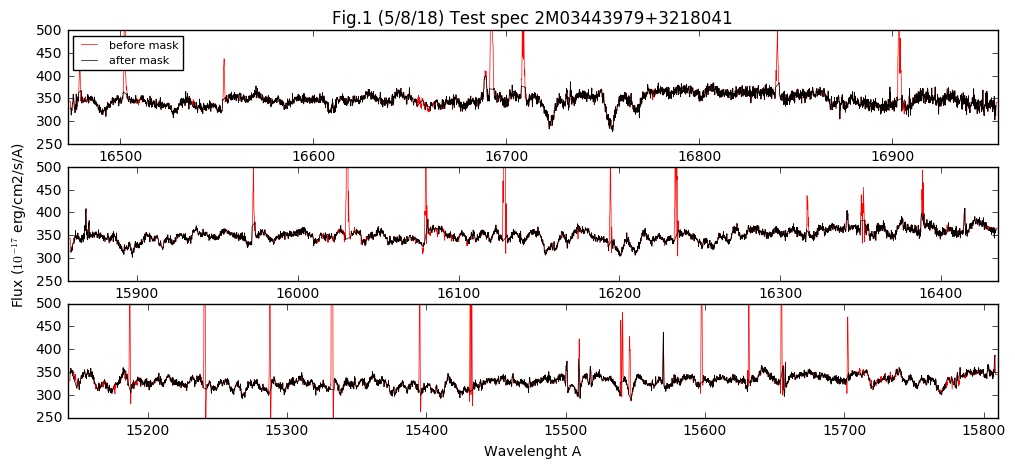

In [122]:
apodir = '/Users/jia/Dropbox/smbhs/ApogeeLine/'
apoid_candidates, j = os.listdir(apodir+'specs_visit'), 8
ifitsfn = apodir+'specs_visit/%s/%s'%(apoid_candidates[j],os.listdir(apodir+'specs_visit/%s'%(apoid_candidates[j]))[0])

ilambda, ispec, ierr, ipass, idate = read_spec(ifitsfn)
f, axes=subplots(3,1,figsize=(12,5))
for i in range(len(ilambda)):
    axes[i].plot(ilambda[i], ispec[i], 'r-',lw=0.5,label='before mask')
    axes[i].plot(ilambda[i][where(ipass[i])], ispec[i][where(ipass[i])], 'k-',lw=0.5,label='after mask')
    axes[i].set_xlim(amin(ilambda[i]),amax(ilambda[i]))
    axes[i].set_ylim(250,500)
axes[1].set_ylabel('Flux ($10^{-17}$ erg/cm2/s/A)') 
axes[-1].set_xlabel('Wavelenght A')
axes[0].set_title('Fig.1 (5/8/18) Test spec '+apoid_candidates[j])
axes[0].legend(fontsize=8,loc='best')
print imask[1]

In [123]:
#from __future__ import absolute_import, division, print_function # Python2 compatibility
os.chdir(apodir+'binspec')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import utils
import spectral_model
import fitting

# read in all individual neural networks we'll need. 
NN_coeffs_norm = utils.read_in_neural_network(name = 'normalized_spectra')
NN_coeffs_flux = utils.read_in_neural_network(name = 'unnormalized_spectra')
NN_coeffs_R = utils.read_in_neural_network(name = 'radius')
NN_coeffs_Teff2_logg2 = utils.read_in_neural_network(name = 'Teff2_logg2')

wavelength = utils.load_wavelength_array()

In [124]:
print (wavelength.shape)
data_spec = interp1d(ilambda[where(ipass)].flatten(), ispec[where(ipass)].flatten())(wavelength)
inorm = mean(mean(data_spec))
data_spec/=inorm
specerr = interp1d(ilambda[where(ipass)].flatten(), ierr[where(ipass)].flatten())(wavelength)/inorm

(7214,)


In [125]:
# fit single-star model
popt_single, pcov, single_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec, 
        spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        p0 = None, num_p0 = 1)

# fit binary model. 
# use the best-fit single-star model ("popt_single") as a starting guess. 
popt_binary, pcov, bin_spec = fitting.fit_normalized_spectrum_binary_model(norm_spec = data_spec, 
        spec_err = specerr, NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R, NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2,
        p0_single = popt_single, num_p0 = 10)

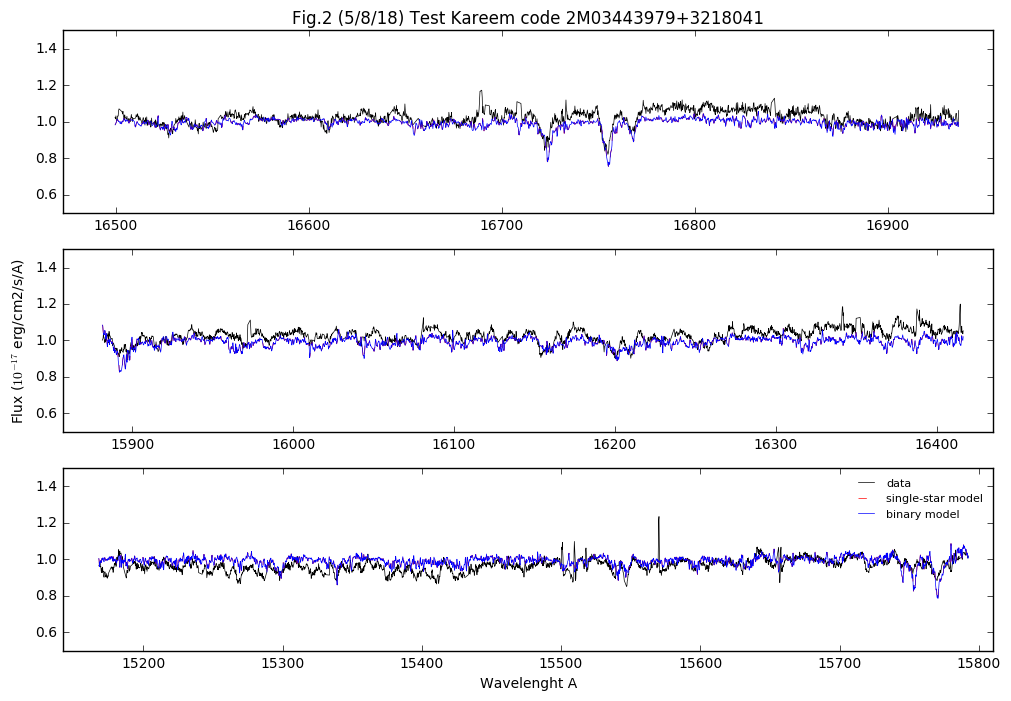

In [128]:
f, axes=subplots(3,1,figsize=(12,8))
for i in range(len(ilambda)):
    m = (wavelength < amax(ilambda[i])) & (wavelength > amin(ilambda[i])) 
    axes[i].plot(wavelength[m], data_spec[m], lw=0.5, color='k',label = 'data')
    axes[i].plot(wavelength[m], single_spec[m], 'r--', lw=0.5, label = 'single-star model')
    axes[i].plot(wavelength[m], bin_spec[m], 'b', lw=0.5, label = 'binary model')
    axes[i].set_xlim(amin(ilambda[i]), amax(ilambda[i]))
    axes[i].set_ylim(0.5, 1.5)
#axes[-1].set_xlim(15300,15400)
legend(loc = 'best', frameon = False, fontsize= 8)
axes[1].set_ylabel('Flux ($10^{-17}$ erg/cm2/s/A)') 
axes[-1].set_xlabel('Wavelenght A')
axes[0].set_title('Fig.2 (5/8/18) Test Kareem code '+apoid_candidates[j])
show()

In [130]:
print popt_single
print popt_binary

[  4.44766118e+03   4.26203504e+00  -9.47975724e-01   3.62822353e-02
   3.23428564e+01   2.25286026e+00]
[  4.44766008e+03   4.26282064e+00  -9.46862427e-01   3.62042888e-02
   1.00000000e+00   3.23428026e+01   3.23428026e+01   2.25428181e+00
   2.25428181e+00]
